In [16]:
!pip install pandas numpy scikit-learn transformers


[notice] A new release of pip is available: 24.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Block 2: Import necessary modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Block 3: Load and preprocess data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [19]:
# Block 4: Define the model
class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [20]:
# Block 5: Prepare data
# Load your CSV file
df = pd.read_csv(r'C:\Users\RTX\Desktop\newia\emotions\Emotion_classify_Data.csv',)  # Replace with your file path

# Preprocess labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Emotion'])

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16

# Create datasets and dataloaders
train_dataset = TextDataset(
    texts=train_df.text.values,
    labels=train_df.label_encoded.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = TextDataset(
    texts=test_df.text.values,
    labels=test_df.label_encoded.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [21]:
# Block 6: Training setup
model = EmotionClassifier(n_classes=len(le.classes_)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
# Block 7: Training loop
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    
    progress_bar = tqdm(data_loader, desc="Training", leave=True)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [23]:
# Block 8: Evaluation function
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [24]:
print(f"Train loader batches: {len(train_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train loader batches: 297
Test loader batches: 75


In [25]:
from tqdm import tqdm
import sys


In [26]:
# Block 9: Run training
EPOCHS = 5  # You can increase this

# Training loop with debug prints
for epoch in range(EPOCHS):
    try:
        print(f"\nStarting epoch {epoch + 1}...")
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Train loss: {train_loss:.4f} Accuracy: {train_acc:.4f}")

        test_acc, test_loss = eval_model(model, test_loader, loss_fn, device)
        print(f"Test loss: {test_loss:.4f} Accuracy: {test_acc:.4f}")
        print('-' * 50)
        sys.stdout.flush()
    except Exception as e:
        print(f"Error during training: {e}")
        break


Starting epoch 1...


Training: 100%|██████████████████████████████████████████████████████████| 297/297 [01:03<00:00,  4.71it/s, loss=0.244]


Epoch 1/5 - Train loss: 0.4510 Accuracy: 0.8176
Test loss: 0.1917 Accuracy: 0.9360
--------------------------------------------------

Starting epoch 2...


Training: 100%|████████████████████████████████████████████████████████| 297/297 [01:01<00:00,  4.84it/s, loss=0.00871]


Epoch 2/5 - Train loss: 0.0982 Accuracy: 0.9657
Test loss: 0.1186 Accuracy: 0.9579
--------------------------------------------------

Starting epoch 3...


Training: 100%|████████████████████████████████████████████████████████| 297/297 [01:01<00:00,  4.83it/s, loss=0.00583]


Epoch 3/5 - Train loss: 0.0484 Accuracy: 0.9827
Test loss: 0.1311 Accuracy: 0.9604
--------------------------------------------------

Starting epoch 4...


Training: 100%|████████████████████████████████████████████████████████| 297/297 [01:01<00:00,  4.82it/s, loss=0.00298]


Epoch 4/5 - Train loss: 0.0355 Accuracy: 0.9869
Test loss: 0.0942 Accuracy: 0.9638
--------------------------------------------------

Starting epoch 5...


Training: 100%|████████████████████████████████████████████████████████| 297/297 [01:01<00:00,  4.82it/s, loss=0.00765]


Epoch 5/5 - Train loss: 0.0315 Accuracy: 0.9884
Test loss: 0.1407 Accuracy: 0.9579
--------------------------------------------------


In [27]:
# Block 10: Save the model
torch.save(model.state_dict(), 'emotion_classifier.pth')

In [28]:
# Block 11: Example of testing with your own text
def predict_emotion(text, model, tokenizer, le, device, max_len=128):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    _, prediction = torch.max(outputs, dim=1)
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    
    return predicted_label

# Example usage:
test_text = "I'm really excited about this new project!"
predicted_emotion = predict_emotion(test_text, model, tokenizer, le, device)
print(f"Text: {test_text}")
print(f"Predicted emotion: {predicted_emotion}")

Text: I'm really excited about this new project!
Predicted emotion: joy


In [29]:
# Example usage:
test_text = "im scared"
predicted_emotion = predict_emotion(test_text, model, tokenizer, le, device)
print(f"Text: {test_text}")
print(f"Predicted emotion: {predicted_emotion}")

Text: im scared
Predicted emotion: fear


In [30]:
print(le.classes_)


['anger' 'fear' 'joy']


Test dataset loaded successfully.
                                               text Emotion
0  I hate when people don't keep their commitments!   anger
1            The sound of thunder always scares me.    fear
2     I saw something move in the corner of my eye.    fear
3    Dancing to my favorite song makes me so happy!     joy
4                 I feel so disrespected right now!   anger


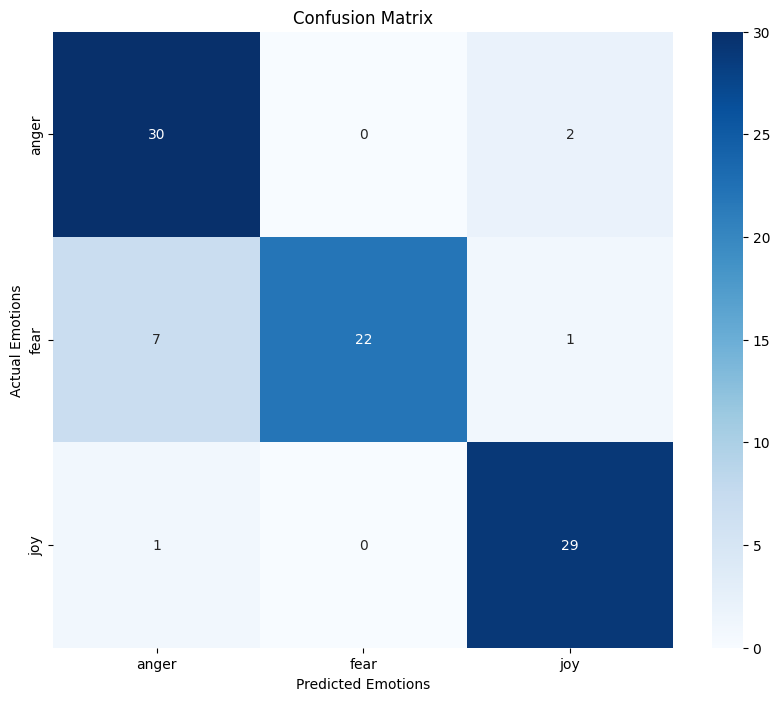

Classification Report:
              precision    recall  f1-score   support

       anger       0.79      0.94      0.86        32
        fear       1.00      0.73      0.85        30
         joy       0.91      0.97      0.94        30

    accuracy                           0.88        92
   macro avg       0.90      0.88      0.88        92
weighted avg       0.90      0.88      0.88        92



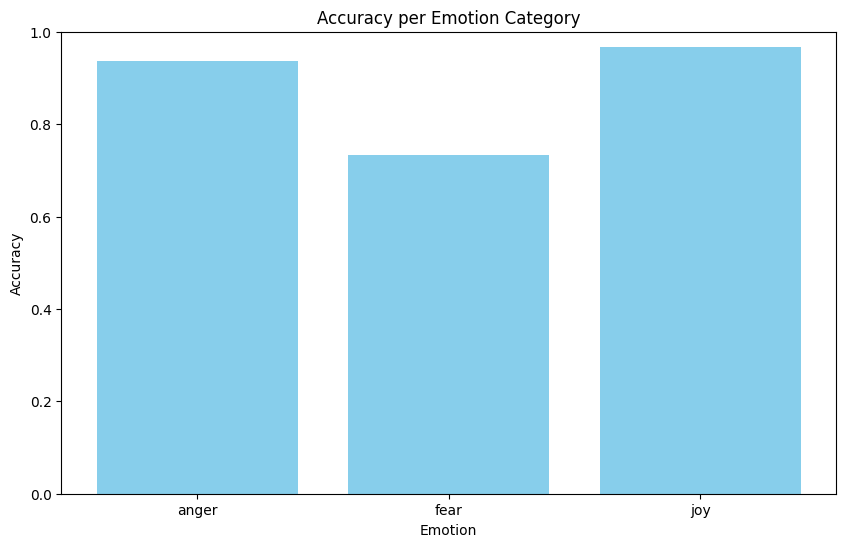

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the test dataset
test_df = pd.read_csv(r'C:\Users\RTX\Desktop\newia\emotions\test.csv')  # Use raw string for Windows path
print("Test dataset loaded successfully.")
print(test_df.head())

# Preprocess the test dataset
test_df['label_encoded'] = le.transform(test_df['Emotion'])  # Encode emotions using the same LabelEncoder

# Create a test dataset and dataloader
test_dataset = TextDataset(
    texts=test_df.text.values,
    labels=test_df.label_encoded.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Evaluate the model on the test dataset
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    return actual_labels, predictions


# Get predictions and actual labels
actual_labels, predictions = evaluate_model(model, test_loader, device)
# Decode labels back to emotion names
actual_emotions = le.inverse_transform(actual_labels)
predicted_emotions = le.inverse_transform(predictions)

# Generate confusion matrix
cm = confusion_matrix(actual_emotions, predicted_emotions, labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotions')
plt.ylabel('Actual Emotions')
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(actual_emotions, predicted_emotions, target_names=le.classes_))

# Plot accuracy per emotion category
emotion_accuracy = {}
for emotion in le.classes_:
    idx = le.transform([emotion])[0]
    correct = np.sum((np.array(actual_labels) == idx) & (np.array(predictions) == idx))
    total = np.sum(np.array(actual_labels) == idx)
    emotion_accuracy[emotion] = correct / total if total > 0 else 0

plt.figure(figsize=(10, 6))
plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color='skyblue')
plt.title('Accuracy per Emotion Category')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()